In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def remove_flat_start(df, tolerance=0.05, min_points=5):
    pos = df.iloc[:, 1].values

    for i in range(1, len(pos) - min_points):
        window = pos[i:i + min_points]
        diffs = abs(window - pos[0])
        if (diffs > tolerance).any():
            return df.iloc[i:].reset_index(drop=True)

    return df.iloc[0:0]

def remove_after_bounce(df, tolerance=1e-3, min_points=3):
    pos = df.iloc[:, 1].to_numpy()
    diff = np.diff(pos)
    for i in range(len(diff) - min_points + 1):
        if (diff[i:i + min_points] > tolerance).all():
            return df.iloc[: i + 1].reset_index(drop=True)
    return df.copy()

def normalize_time(df):
    df = df.copy()
    df['t'] = df['t'] - df['t'].iloc[0]
    return df

def merge_mass_tables(tables):
    merged = []
    for table in tables:
        temp = table.copy()
        temp.columns = ['t', 'y']
        merged.append(temp)
    return pd.concat(merged, ignore_index=True)

In [3]:
rdf_ball = pd.read_csv('data/pelota.csv')
rdf_1f = pd.read_csv('data/filtros0_cafe.csv')
rdf_2f = pd.read_csv('data/filtros1_cafe.csv')
rdf_3f = pd.read_csv('data/filtros2_cafe.csv')

In [4]:
rdf_ball = rdf_ball[rdf_ball.drop(columns='t').notna().any(axis=1)]
df = rdf_ball.iloc[:,:-1]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 236 entries, 0 to 3233
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       236 non-null    float64
 1   mass A  67 non-null     float64
 2   mass B  43 non-null     float64
 3   mass C  45 non-null     float64
 4   mass D  39 non-null     float64
 5   mass E  42 non-null     float64
dtypes: float64(6)
memory usage: 12.9 KB


In [5]:
mass_cols = sorted(c for c in df.columns if c.startswith('mass'))
df_list = [df[['t', m]].dropna() for m in mass_cols]

filtered_df_list = []
for d in df_list:
    d1 = remove_flat_start(d, tolerance=0.1, min_points=11)
    if d1.empty:
        continue
    d2 = remove_after_bounce(d1, tolerance=0.01, min_points=2)
    if d2.empty:
        continue
    d_norm = normalize_time(d2)
    filtered_df_list.append(d_norm)

df_ball = merge_mass_tables(filtered_df_list)

In [6]:
bin_size = 0.025
df_ball['t_bin'] = (df_ball['t'] / bin_size).round().mul(bin_size)
grouped = df_ball.groupby('t_bin')

delta_y_tracker = 0.02 * 2.2
delta_flexometro = 0.001
systematic_uncertainty = delta_y_tracker**2 + delta_flexometro**2

summary = {'t': [], 'y_mean': [], 'sem': [], 'total_uncertainty': []}

for t_val, grp in grouped:
    y_mean = grp['y'].mean()
    n = len(grp)
    sem = grp['y'].std(ddof=1) / np.sqrt(n) if n > 1 else 0.0
    total_uncertainty = np.sqrt(sem**2 + systematic_uncertainty)
    summary['t'].append(t_val)
    summary['y_mean'].append(y_mean)
    summary['sem'].append(sem)
    summary['total_uncertainty'].append(total_uncertainty)

fdf_ball = pd.DataFrame(summary)

In [7]:
print(fdf_ball)

        t    y_mean       sem  total_uncertainty
0   0.000  2.015349  0.000951           0.044022
1   0.025  2.015811  0.000625           0.044016
2   0.050  2.011257  0.001453           0.044035
3   0.075  2.000981  0.002338           0.044073
4   0.100  1.980594  0.003018           0.044115
5   0.125  1.956379  0.003521           0.044152
6   0.150  1.925078  0.003692           0.044166
7   0.175  1.881701  0.005763           0.044387
8   0.200  1.836571  0.005684           0.044377
9   0.225  1.783295  0.007598           0.044662
10  0.250  1.723827  0.007177           0.044593
11  0.275  1.656975  0.009369           0.044997
12  0.300  1.584013  0.008385           0.044803
13  0.325  1.497436  0.010874           0.045335
14  0.350  1.410046  0.008794           0.044881
15  0.375  1.312704  0.012927           0.045871
16  0.400  1.209435  0.007895           0.044714
17  0.425  1.095699  0.015523           0.046669
18  0.450  0.980092  0.014285           0.046272
19  0.475  0.855910 

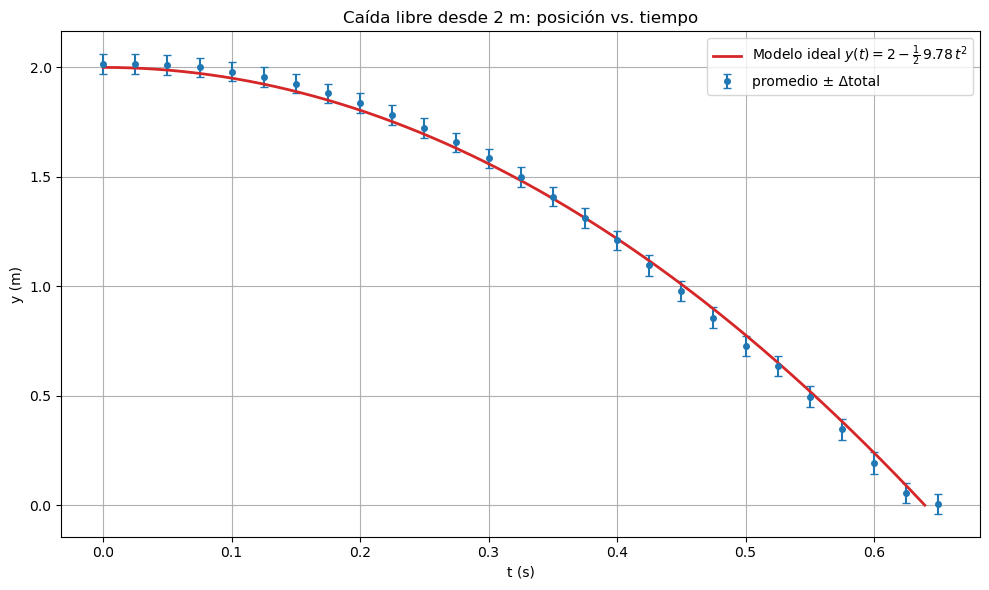

In [8]:
g = 9.78
h = 2.0

t_end = np.sqrt(2 * h / g)
t_model = np.linspace(0, t_end, 500)
y_model = h - 0.5 * g * t_model**2

plt.figure(figsize=(10, 6))

plt.errorbar(
    fdf_ball['t'],
    fdf_ball['y_mean'],
    yerr=fdf_ball['total_uncertainty'],
    fmt='o', markersize=4, capsize=3,
    label='promedio ± Δtotal'
)

plt.plot(
    t_model,
    y_model,
    color='tab:red',
    linewidth=2,
    label=r'Modelo ideal $y(t)=2-\frac{1}{2}\,9.78\,t^{2}$'
)

plt.xlabel('t (s)')
plt.ylabel('y (m)')
plt.title('Caída libre desde 2 m: posición vs. tiempo')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
fdf_ball['y_model'] = h - 0.5 * g * fdf_ball['t']**2
fdf_ball['residual'] = fdf_ball['y_mean'] - fdf_ball['y_model']

mae  = fdf_ball['residual'].abs().mean()
rmse = np.sqrt((fdf_ball['residual']**2).mean())

fdf_ball['z_score'] = fdf_ball['residual'] / fdf_ball['total_uncertainty']

within_1sigma = (fdf_ball['z_score'].abs() <= 1).mean() * 100
within_2sigma = (fdf_ball['z_score'].abs() <= 2).mean() * 100

z_score_std = fdf_ball['z_score'].std(ddof=1)

print(f"MAE: {mae:.6f} m")
print(f"RMSE: {rmse:.6f} m")
print(f"% dentro 1σ: {within_1sigma:.1f}%")
print(f"% dentro 2σ: {within_2sigma:.1f}%")
print(f"σ(z): {z_score_std:.3f}")

MAE: 0.028221 m
RMSE: 0.031542 m
% dentro 1σ: 92.6%
% dentro 2σ: 100.0%
σ(z): 0.692


In [10]:
rdf_1f = rdf_1f[rdf_1f.drop(columns='t').notna().any(axis=1)]
df = rdf_1f.iloc[:,:-1]

In [11]:
mass_cols = sorted(c for c in df.columns if c.startswith('mass'))

df_list = [
    df[['t', m]].dropna()
    for m in mass_cols
]

filtered_df_list = []

for d in df_list:
    d_cut = remove_flat_start(d, tolerance=0.1, min_points=11)
    if not d_cut.empty:
        d_norm = normalize_time(d_cut)
        filtered_df_list.append(d_norm)

df_1f = merge_mass_tables(filtered_df_list)
df_1f["y"] = df_1f["y"] * 2

In [12]:
bin_size = 0.025
df_1f['t_bin'] = (df_1f['t'] / bin_size).round().mul(bin_size)
grouped = df_1f.groupby('t_bin')

delta_y_tracker = 0.02 * 2.2
delta_flexometro = 0.001
delta_time = 1/30
systematic_uncertainty = delta_y_tracker**2 + delta_flexometro**2 + delta_time**2

summary = {'t': [], 'y_mean': [], 'sem': [], 'total_uncertainty': []}

for t_val, grp in grouped:
    y_mean = grp['y'].mean()
    n = len(grp)
    sem = grp['y'].std(ddof=1) / np.sqrt(n) if n > 1 else 0.0
    total_uncertainty = np.sqrt(sem**2 + systematic_uncertainty)
    summary['t'].append(t_val)
    summary['y_mean'].append(y_mean)
    summary['sem'].append(sem)
    summary['total_uncertainty'].append(total_uncertainty)

df_1f = pd.DataFrame(summary)

In [13]:
rdf_2f = rdf_2f[rdf_2f.drop(columns='t').notna().any(axis=1)]
df = rdf_2f.iloc[:,:-1]

In [14]:
mass_cols = sorted(c for c in df.columns if c.startswith('mass'))

df_list = [
    df[['t', m]].dropna()
    for m in mass_cols
]

filtered_df_list = []

for d in df_list:
    d_cut = remove_flat_start(d, tolerance=0.1, min_points=11)
    if not d_cut.empty:
        d_norm = normalize_time(d_cut)
        filtered_df_list.append(d_norm)

df_2f = merge_mass_tables(filtered_df_list)

In [15]:
bin_size = 0.025
df_2f['t_bin'] = (df_2f['t'] / bin_size).round().mul(bin_size)
grouped = df_2f.groupby('t_bin')

delta_y_tracker = 0.02 * 2.2
delta_flexometro = 0.001
delta_time = 1/30
systematic_uncertainty = delta_y_tracker**2 + delta_flexometro**2 + delta_time**2

summary = {'t': [], 'y_mean': [], 'sem': [], 'total_uncertainty': []}

for t_val, grp in grouped:
    y_mean = grp['y'].mean()
    n = len(grp)
    sem = grp['y'].std(ddof=1) / np.sqrt(n) if n > 1 else 0.0
    total_uncertainty = np.sqrt(sem**2 + systematic_uncertainty)
    summary['t'].append(t_val)
    summary['y_mean'].append(y_mean)
    summary['sem'].append(sem)
    summary['total_uncertainty'].append(total_uncertainty)

df_2f = pd.DataFrame(summary)

In [16]:
rdf_3f = rdf_3f[rdf_3f.drop(columns='t').notna().any(axis=1)]
df = rdf_3f.iloc[:,:-1]

In [17]:
mass_cols = sorted(c for c in df.columns if c.startswith('mass'))

df_list = [
    df[['t', m]].dropna()
    for m in mass_cols
]

filtered_df_list = []

for d in df_list:
    d_cut = remove_flat_start(d, tolerance=0.1, min_points=11)
    if not d_cut.empty:
        d_norm = normalize_time(d_cut)
        filtered_df_list.append(d_norm)

df_3f = merge_mass_tables(filtered_df_list)

In [18]:
bin_size = 0.025
df_3f['t_bin'] = (df_3f['t'] / bin_size).round().mul(bin_size)
grouped = df_3f.groupby('t_bin')

delta_y_tracker = 0.02 * 2.2
delta_flexometro = 0.001
delta_time = 1/30
systematic_uncertainty = delta_y_tracker**2 + delta_flexometro**2 + delta_time**2

summary = {'t': [], 'y_mean': [], 'sem': [], 'total_uncertainty': []}

for t_val, grp in grouped:
    y_mean = grp['y'].mean()
    n = len(grp)
    sem = grp['y'].std(ddof=1) / np.sqrt(n) if n > 1 else 0.0
    total_uncertainty = np.sqrt(sem**2 + systematic_uncertainty)
    summary['t'].append(t_val)
    summary['y_mean'].append(y_mean)
    summary['sem'].append(sem)
    summary['total_uncertainty'].append(total_uncertainty)

df_3f = pd.DataFrame(summary)

In [25]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_3f)

# fig, axs = plt.subplots(1, 3, figsize=(18, 4))
# axs = axs.flatten()
#
# for i, df in enumerate([df_1f, df_2f, df_3f]):
#     x_col = df['t']
#     y_col = df['y']
#
#     axs[i].scatter(x_col, y_col, s=5)
#     axs[i].set_title(f"Número de filtros: {i + 1}")
#     axs[i].set_xlabel("t (s)")
#     axs[i].set_ylabel("y (m)")
#     axs[i].grid(True)
#
# plt.tight_layout()
# plt.show()

        t    y_mean       sem  total_uncertainty
0   0.000  2.111025  0.008266           0.055825
1   0.025  2.105375  0.006584           0.055601
2   0.050  2.097615  0.010767           0.056250
3   0.075  2.082317  0.007716           0.055746
4   0.100  2.065586  0.009700           0.056055
5   0.125  2.044005  0.007404           0.055704
6   0.150  2.015686  0.011883           0.056474
7   0.175  1.986531  0.008428           0.055849
8   0.200  1.951658  0.012042           0.056508
9   0.225  1.921635  0.009165           0.055965
10  0.250  1.882013  0.013840           0.056918
11  0.275  1.839310  0.011007           0.056296
12  0.300  1.796513  0.015551           0.057358
13  0.325  1.744493  0.012921           0.056702
14  0.350  1.698091  0.018151           0.058117
15  0.375  1.645310  0.015445           0.057329
16  0.400  1.587568  0.022428           0.059591
17  0.425  1.529831  0.018395           0.058193
18  0.450  1.473595  0.026015           0.061032
19  0.475  1.432477 

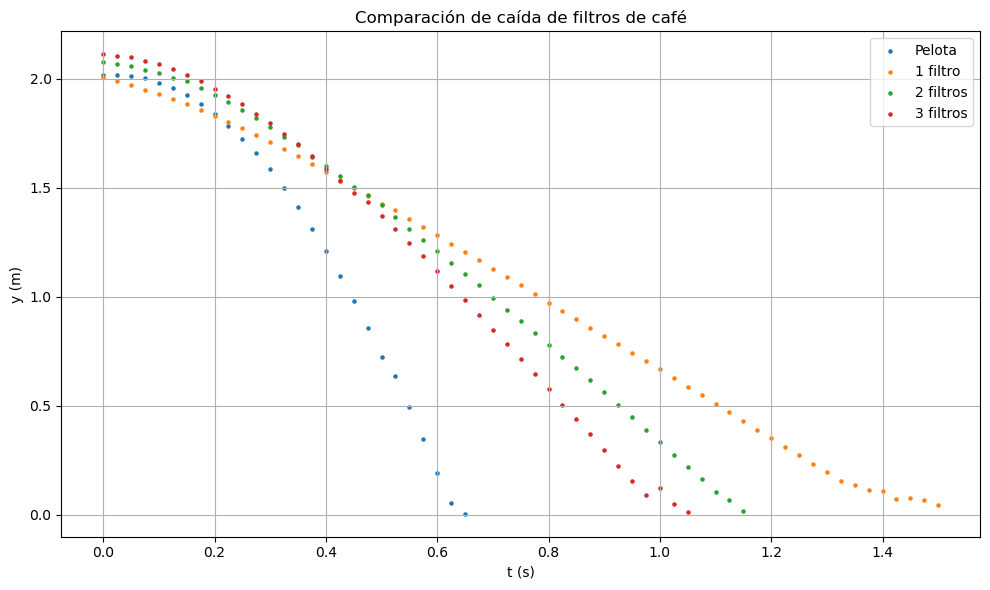

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(fdf_ball['t'], fdf_ball['y_mean'], s=5, label='Pelota')
plt.scatter(df_1f['t'], df_1f['y_mean'], s=5, label='1 filtro')
plt.scatter(df_2f['t'], df_2f['y_mean'], s=5, label='2 filtros')
plt.scatter(df_3f['t'], df_3f['y_mean'], s=5, label='3 filtros')
plt.xlabel('t (s)')
plt.ylabel('y (m)')
plt.title('Comparación de caída de filtros de café')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()